In [4]:
# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification'

# prepared dataset
dataset_path = '/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification/nature_data.npz'

# saved model name
model_name = 'best_pretrained_VGG16.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [5]:
import numpy as np

In [6]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [9]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [15]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [16]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [17]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Model

### Baseline model : 

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [19]:
# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

58892288/58889256 [==============================] - 1s 0us/step


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [21]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 11s 47ms/step - loss: 2.0655 - fbeta: 0.6458 - val_loss: 0.5203 - val_fbeta: 0.7877
Epoch 2/200
64/64 [==============================] - 3s 39ms/step - loss: 0.1551 - fbeta: 0.9253 - val_loss: 0.4876 - val_fbeta: 0.8011
Epoch 3/200
64/64 [==============================] - 3s 39ms/step - loss: 0.0523 - fbeta: 0.9712 - val_loss: 0.5012 - val_fbeta: 0.8220
Epoch 4/200
64/64 [==============================] - 3s 39ms/step - loss: 0.0129 - fbeta: 0.9933 - val_loss: 0.5608 - val_fbeta: 0.8066
Epoch 5/200
64/64 [==============================] - 2s 39ms/step - loss: 0.0074 - fbeta: 0.9964 - val_loss: 0.5115 - val_fbeta: 0.8140
Epoch 6/200
64/64 [==============================] - 3s 40ms/step - loss: 0.0027 - fbeta: 0.9997 - val_loss: 0.5319 - val_fbeta: 0.8159
Epoch 7/200
64/64 [==============================] - 3s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5531 - val_fbeta: 0.8038
Epoch 8/200
64/64 [============================

In [22]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

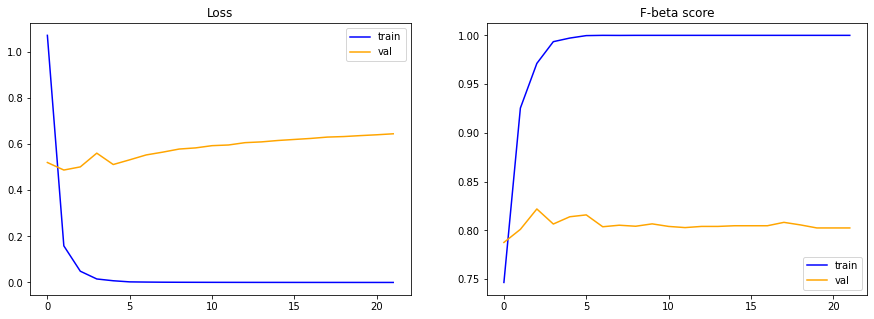

Model F-beta score :  0.7918835282325745


In [23]:
baseline_perf = evaluate_model(history)

Note : overfitting

## Improved Models

### model 1 : set last VGG block as trainable

Epoch 1/200
64/64 [==============================] - 4s 54ms/step - loss: 2978.3628 - fbeta: 0.2144 - val_loss: 0.6309 - val_fbeta: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 3s 53ms/step - loss: 0.6160 - fbeta: 0.0000e+00 - val_loss: 0.5811 - val_fbeta: 0.0000e+00
Epoch 3/200
64/64 [==============================] - 3s 50ms/step - loss: 0.5729 - fbeta: 0.0000e+00 - val_loss: 0.5642 - val_fbeta: 0.0000e+00
Epoch 4/200
64/64 [==============================] - 3s 51ms/step - loss: 0.5622 - fbeta: 0.0000e+00 - val_loss: 0.5593 - val_fbeta: 0.0000e+00
Epoch 5/200
64/64 [==============================] - 3s 51ms/step - loss: 0.5538 - fbeta: 0.0000e+00 - val_loss: 0.5582 - val_fbeta: 0.0000e+00
Epoch 6/200
64/64 [==============================] - 3s 51ms/step - loss: 0.5539 - fbeta: 0.0000e+00 - val_loss: 0.5577 - val_fbeta: 0.0000e+00
Epoch 7/200
64/64 [==============================] - 3s 51ms/step - loss: 0.5496 - fbeta: 0.0000e+00 - val_loss: 0.5575 - val_fbeta: 0.00

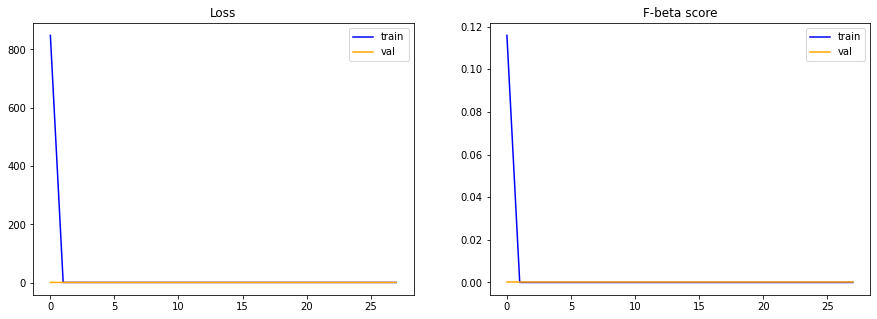

Model F-beta score :  0.0017857140628620982


In [28]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last vgg block as trainable
model.get_layer('block5_conv1').trainable = True
model.get_layer('block5_conv2').trainable = True
model.get_layer('block5_conv3').trainable = True
model.get_layer('block5_pool').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# optimizer 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01)

# compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model1_perf = evaluate_model(history)

Note : model doesn't learn properly, need to adjust learning rate

### model 2 : Baseline model + dropout layer

Epoch 1/200
64/64 [==============================] - 4s 48ms/step - loss: 1.8682 - fbeta: 0.6239 - val_loss: 0.3493 - val_fbeta: 0.7261
Epoch 2/200
64/64 [==============================] - 3s 43ms/step - loss: 0.2356 - fbeta: 0.8445 - val_loss: 0.3061 - val_fbeta: 0.7888
Epoch 3/200
64/64 [==============================] - 3s 43ms/step - loss: 0.1602 - fbeta: 0.8942 - val_loss: 0.3449 - val_fbeta: 0.8049
Epoch 4/200
64/64 [==============================] - 3s 43ms/step - loss: 0.1444 - fbeta: 0.9171 - val_loss: 0.3563 - val_fbeta: 0.8107
Epoch 5/200
64/64 [==============================] - 3s 43ms/step - loss: 0.1302 - fbeta: 0.9159 - val_loss: 0.3538 - val_fbeta: 0.8285
Epoch 6/200
64/64 [==============================] - 3s 43ms/step - loss: 0.1005 - fbeta: 0.9410 - val_loss: 0.3485 - val_fbeta: 0.8438
Epoch 7/200
64/64 [==============================] - 3s 43ms/step - loss: 0.0963 - fbeta: 0.9498 - val_loss: 0.4264 - val_fbeta: 0.8115
Epoch 8/200
64/64 [=============================

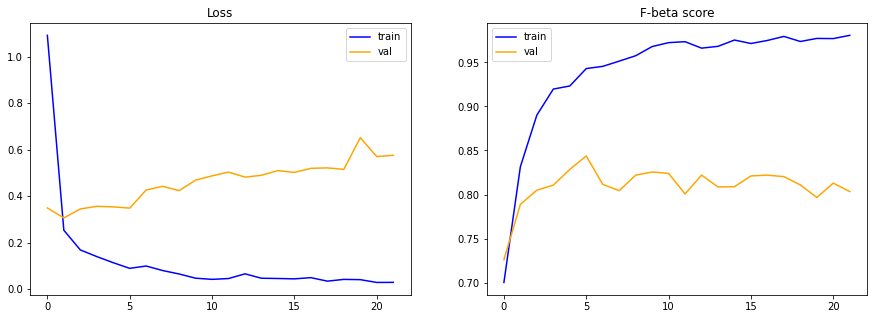

Model F-beta score :  0.8072909712791443


In [34]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)

# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_perf = evaluate_model(history)

Note : overfitting, fbeta score is high

### model 3 : Baseline model + data augmentation

Epoch 1/200
64/64 [==============================] - 7s 103ms/step - loss: 2.0238 - fbeta: 0.4872 - val_loss: 0.4293 - val_fbeta: 0.6315
Epoch 2/200
64/64 [==============================] - 6s 98ms/step - loss: 0.3742 - fbeta: 0.6695 - val_loss: 0.3661 - val_fbeta: 0.6831
Epoch 3/200
64/64 [==============================] - 7s 102ms/step - loss: 0.3419 - fbeta: 0.7126 - val_loss: 0.3387 - val_fbeta: 0.7015
Epoch 4/200
64/64 [==============================] - 6s 98ms/step - loss: 0.2816 - fbeta: 0.7505 - val_loss: 0.3414 - val_fbeta: 0.7079
Epoch 5/200
64/64 [==============================] - 6s 96ms/step - loss: 0.2564 - fbeta: 0.7812 - val_loss: 0.3290 - val_fbeta: 0.7204
Epoch 6/200
64/64 [==============================] - 6s 97ms/step - loss: 0.2269 - fbeta: 0.7949 - val_loss: 0.3397 - val_fbeta: 0.7265
Epoch 7/200
64/64 [==============================] - 6s 97ms/step - loss: 0.2295 - fbeta: 0.8190 - val_loss: 0.3147 - val_fbeta: 0.7272
Epoch 8/200
64/64 [===========================

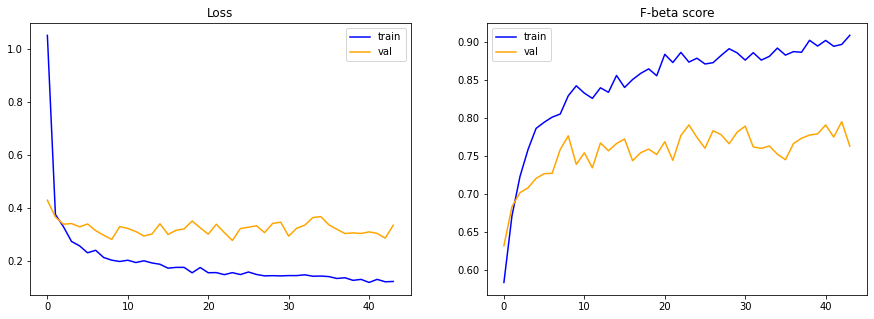

Model F-beta score :  0.8429853916168213


In [45]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model3_perf = evaluate_model(history)

Note : overfitting is reduced, fbeta score is high

### model 4 : Baseline model + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 7s 101ms/step - loss: 2.5607 - fbeta: 0.4952 - val_loss: 0.5291 - val_fbeta: 0.5113
Epoch 2/200
64/64 [==============================] - 6s 99ms/step - loss: 0.5128 - fbeta: 0.5068 - val_loss: 0.3935 - val_fbeta: 0.6309
Epoch 3/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4640 - fbeta: 0.5825 - val_loss: 0.3745 - val_fbeta: 0.5906
Epoch 4/200
64/64 [==============================] - 6s 97ms/step - loss: 0.4120 - fbeta: 0.6026 - val_loss: 0.3831 - val_fbeta: 0.6098
Epoch 5/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4053 - fbeta: 0.6152 - val_loss: 0.3741 - val_fbeta: 0.6418
Epoch 6/200
64/64 [==============================] - 6s 96ms/step - loss: 0.3672 - fbeta: 0.6168 - val_loss: 0.3360 - val_fbeta: 0.6425
Epoch 7/200
64/64 [==============================] - 6s 96ms/step - loss: 0.3491 - fbeta: 0.6525 - val_loss: 0.3360 - val_fbeta: 0.6720
Epoch 8/200
64/64 [============================

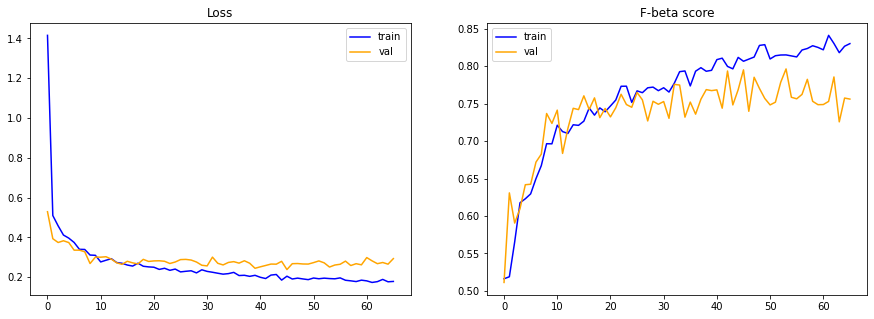

Model F-beta score :  0.7909111976623535


In [46]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_perf = evaluate_model(history)

Note : overfitting is reduced but get increase again in later epochs, the performance is lower.

### model 5 : Baseline model + data augmentation + dropout layers + more dense layers

Epoch 1/200
64/64 [==============================] - 7s 103ms/step - loss: 3.3058 - fbeta: 0.3774 - val_loss: 0.4744 - val_fbeta: 0.5869
Epoch 2/200
64/64 [==============================] - 6s 96ms/step - loss: 0.8942 - fbeta: 0.4655 - val_loss: 0.4241 - val_fbeta: 0.4500
Epoch 3/200
64/64 [==============================] - 6s 97ms/step - loss: 0.5439 - fbeta: 0.4623 - val_loss: 0.4341 - val_fbeta: 0.5347
Epoch 4/200
64/64 [==============================] - 6s 98ms/step - loss: 0.5404 - fbeta: 0.4641 - val_loss: 0.3623 - val_fbeta: 0.6187
Epoch 5/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4811 - fbeta: 0.5449 - val_loss: 0.3768 - val_fbeta: 0.5532
Epoch 6/200
64/64 [==============================] - 6s 98ms/step - loss: 0.4896 - fbeta: 0.4636 - val_loss: 0.3871 - val_fbeta: 0.5370
Epoch 7/200
64/64 [==============================] - 6s 97ms/step - loss: 0.4469 - fbeta: 0.4829 - val_loss: 0.3818 - val_fbeta: 0.5387
Epoch 8/200
64/64 [============================

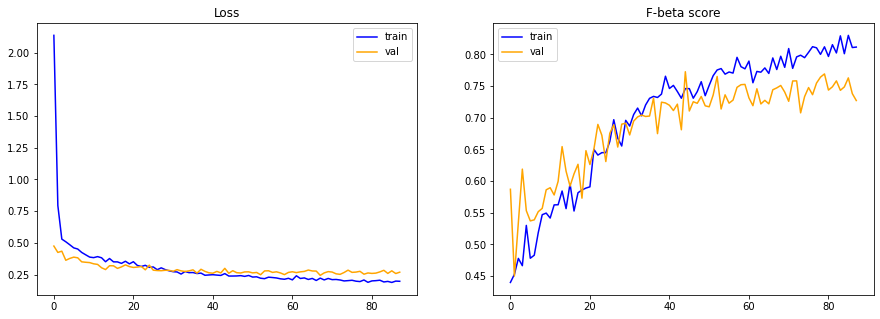

Model F-beta score :  0.8036981821060181


In [47]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.3)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.3)(class2)
output = Dense(5, activation='sigmoid')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_perf = evaluate_model(history)

Note : overfitting is reduced

In [49]:
print('Baseline model : ', baseline_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)
print('Model 5 : ', model5_perf)

Baseline model :  0.7918835282325745
Model 1 :  0.0017857140628620982
Model 2 :  0.8072909712791443
Model 3 :  0.8429853916168213
Model 4 :  0.7909111976623535
Model 5 :  0.8036981821060181


Note : 
- model 2, 3  are overfitting  
- model 4, 5 overfitting is reduced

## Finalize model 5
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [50]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.3)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.3)(class2)
output = Dense(5, activation='sigmoid')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)

Epoch 1/300
64/64 [==============================] - 7s 100ms/step - loss: 3.4435 - val_loss: 0.5249

Epoch 00001: val_loss improved from inf to 0.52486, saving model to best_pretrained_VGG16.h5
Epoch 2/300
64/64 [==============================] - 6s 96ms/step - loss: 0.8351 - val_loss: 0.4565

Epoch 00002: val_loss improved from 0.52486 to 0.45652, saving model to best_pretrained_VGG16.h5
Epoch 3/300
64/64 [==============================] - 6s 96ms/step - loss: 0.5737 - val_loss: 0.4327

Epoch 00003: val_loss improved from 0.45652 to 0.43269, saving model to best_pretrained_VGG16.h5
Epoch 4/300
64/64 [==============================] - 6s 96ms/step - loss: 0.5441 - val_loss: 0.4163

Epoch 00004: val_loss improved from 0.43269 to 0.41635, saving model to best_pretrained_VGG16.h5
Epoch 5/300
64/64 [==============================] - 6s 98ms/step - loss: 0.4803 - val_loss: 0.3778

Epoch 00005: val_loss improved from 0.41635 to 0.37776, saving model to best_pretrained_VGG16.h5
Epoch 6/300
6

## Evaluate model

In [51]:
# print y_test
y_test[:5]

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [59]:
# get y_pred
y_pred = model.predict(test_iter)
y_pred = y_pred.round()
print('y_pred shape : ', y_pred.shape)
print(y_pred[:5])

y_pred shape :  (400, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [60]:
# print model score
final_model_fbeta = fbeta(y_test, y_pred)
print('final_model_fbeta : ', final_model_fbeta.numpy())

final_model_fbeta :  0.80617976


In [61]:
!ls

best_pretrained_VGG16.h5  drive  sample_data


In [62]:
# copy saved model file to the project directory
import shutil
import os

shutil.copyfile(model_name, os.path.join(project_dir,model_name))

'/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification/best_pretrained_VGG16.h5'